
# Training StyleGAN2-ADA-Pytorch in Google CoLab Pro

Special thanks: This notebook was built based on John Heaton's notebook https://www.youtube.com/watch?v=BCde68k6KXg. Jeff's notebook didn't run as supposed to on my environment so I am sharing my notebook to help others who faced same issues.

Note: This GAN was trained in Colab Pro using a GPU runtime. I am based in the UK and even thought I am Google CoLab Pro I was served a K80 (the worst) in many occasions! In some occations Google cut me off after 6 hours of training when its supposed to cut me off after 24 hours on Pro.





# What Sort of GPU are you assigned?

The type of GPU assigned to you by Colab will greatly affect your training time. Some sample times that I achieved with Colab are given here. 

* 1024x1024 - V100 - 566 sec/tick (CoLab Pro)
* 1024x1024 - P100 - 1819 sec/tick (CoLab Pro)
* 1024x1024 - T4 - 2188 sec/tick (CoLab Free)
* K80 lowest




Note: Google Colab will check if you are on your screen by prompting you to tick a captcha pop-up. If you miss it you ll be disconnect. At the time of writing 10-Sep-21 there was no way around it. 

Type the command below to see what GPU Google CoLab assigned you

In [ ]:
!nvidia-smi

Mon Sep 20 07:56:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Set Up New Environment

You will likely need to train for >24 hours.  Colab will disconnect you.  You must be prepared to restart training when this eventually happens.  Training is divided into ticks, every so many ticks (50 by default) your neural network is evaluated and a snapshot is saved.  When CoLab shuts down, all training after the last snapshot is lost. It might seem desirable to snapshot after each tick; however, this snapshotting process itself takes nearly an hour.  It is important to learn an optimal snapshot size for your resolution and training data.

We will mount GDRIVE so that your snapshots are saved there.  You must also place your training images in GDRIVE.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


# Set your folders properly



I do all my storage on my gdrive. If you do on Google Colab you will lose it the moment it disconnects from the instance. 

* ./data/gan/images - RAW images I wish to train on.
* ./data/gan/datasets - Actual training datasets that I convert from the raw images.
* ./data/gan/experiments - The output from StyleGAN2, my image previews and saved network snapshots.
* ./data/gan/output - this is the folder where I store images generated

The drive is mounted to the following location.

```
/content/drive/MyDrive/data
```

It might be helpful to use an ```ls``` command to establish the exact path for your images.

In [ ]:
!ls /content/drive/MyDrive/data/gan/images

paint


Here I install NVIDIA StyleGAN2 ADA PyTorch and other packages that I was missing. It is important to install pytorch 1.7 as Google Colab starts the environemnt with pytorch 1.9. 

Note: The packages need to be installed every time you connect to the instance.


In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
!pip install imageio-ffmpeg==0.4.3
!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 108 kB 8.1 MB/s 
     |████████████████████████████████| 26.9 MB 90.4 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.4 MB/s eta 0:03:54tcmalloc: large alloc 1147494400 bytes == 0x55813d35c000 @  0x7f4d758e2615 0x558104bb44cc 0x558104c9447a 0x558104bb72ed 0x558104ca8e1d 0x558104c2ae99 0x558104c259ee 0x558104bb8bda 0x558104c2ad00 0x558104c259ee 0x558104bb8bda 0x558104c27737 0x558104ca9c66 0x558104c26daf 0x558104ca9c66 0x558104c26daf 0x558104ca9c66 0x558104c26daf 0x558104bb9039 0x558104bfc409 0x558104bb7c52 0x558104c2ac25 0x558104c259ee 0x558104bb8bda 0x558104c27737 0x558104c259ee 0x558104bb8bda 0x558104c26915 0x558104bb8afa 0x5

I didnt need the below packages but a few suggest to install them. Install only if the code doesnt run.

In [ ]:
#!pip install click
#!pip install tqdm
#!pip install requests
#!pip install psutil
#!pip install scipy

# Convert Your Images


This is where the work starts. The below command was useful. My training set was 650x450 and this quick command change it to a uniform 512x512. Pytorch is very specific on what dimensions of data set accepts for training. They must be square 256x256, 512x512, 1024x1024. The bigger they are the more training they need. Try to have at least 1000 training photos for good results.

In [ ]:
!python /content/stylegan2-ada-pytorch/dataset_tool.py --source /content/drive/MyDrive/data/gan/images/paint/ --dest /content/drive/MyDrive/data/gan/dataset/paint --width 512 --height 512

100% 399/399 [01:39<00:00,  4.03it/s]


The following command can be used to clear out the newly created dataset.  If something goes wrong and you need to clean up your images and rerun the above command, you should delete your partially created dataset directory.

In [ ]:
#!rm -R /content/drive/MyDrive/data/gan/dataset/paint/*

# Clean Up your Images (I didnt used this piece of code)

It is important that all images have the same dimensions and color depth.  This code can identify images that have issues.

In [ ]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/MyDrive/data/gan/images/fish'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and sz!=base_size:
    print(f"Inconsistant size: {file2}")
  elif img.mode!='RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz


#Simple (Initial) Training (no snapshots)

NVIDIA made it so easy to use their baby. This command starts training of the GAN just by giving it a few parameters. I suggest to put metrics==none so you save time on every tick otherwise your GAN will take extra minutes I believe around 10 mins (depending GPU) to present you with the metrics of the tick. 

In [ ]:
!/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --data /content/drive/MyDrive/data/gan/dataset/paint --outdir /content/drive/MyDrive/data/gan/experiments --metrics=none --gpus=1 


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 50,
  "network_snapshot_ticks": 50,
  "metrics": [],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/dataset/paint",
    "use_labels": false,
    "max_size": 399,
    "xflip": false,
    "resolution": 512
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512

# Perform Initial Training (Snapshots taken)


This command is slightly better than the one above. This command has a parameter called "snap". SNAP is very simply on how many ticks you want to get a snap-shot of your code in order to come around the Google Colab disconnect. For example SNAP = 10 means that every 10 ticks it will take a snapshot of your training. You will need to modify this at later stages depending what GPU you have. Slow GPU smaller SNAP, faster GPU larger snap.

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
DATA = "/content/drive/MyDrive/data/gan/dataset/paint"
SNAP = 10 

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --snap {SNAP} --outdir {EXPERIMENTS} --data {DATA}"
!{cmd}

# Resume Training

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
NETWORK = "network-snapshot-000020.pkl"
RESUME = os.path.join(EXPERIMENTS, "00010-paint-auto1-resumecustom", NETWORK)
DATA = "/content/drive/MyDrive/data/gan/dataset/paint"
SNAP = 5 #snap = x means that every x ticks it will take a snapshot of your training

# Build the command and run it
!/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --snap {SNAP} --resume {RESUME} --outdir {EXPERIMENTS} --data {DATA} --metrics=none --gpus=1  


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 5,
  "network_snapshot_ticks": 5,
  "metrics": [],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/data/gan/dataset/paint",
    "use_labels": false,
    "max_size": 399,
    "xflip": false,
    "resolution": 512
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 32768,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 32768,
    "channel_max": 512,


#Generating images

Generate Single Images
--network: Make sure the --network argument points to your .pkl file. (My preferred method is to right click on the file in the Files pane to your left and choose Copy Path, then paste that into the argument after the = sign).

--seeds: This allows you to choose random seeds from the model. Remember that our input to StyleGAN is a 512-dimensional array. These seeds will generate those 512 values. Each seed will generate a different, random array. The same seed value will also always generate the same random array, so we can later use it for other purposes like interpolation.

--truncation: Truncation, well, truncates the latent space. This can have a subtle or dramatic affect on your images depending on the value you use. The smaller the number the more realistic your images should appear, but this will also affect diversity. Most people choose between 0.5 and 1.0, but technically it's infinite.

In [ ]:
!/usr/bin/python3 /content/stylegan2-ada-pytorch/generate.py --outdir /content/drive/MyDrive/data/gan/output/ --trunc=0.5 --seeds=85,265,297,849 \
    --network /content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl"...
Generating image for seed 85 (0/4) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 265 (1/4) ...
Generating image for seed 297 (2/4) ...
Generating image for seed 849 (3/4) ...


Add the StyleGAN folder to Python so that you can import it. The code below is based on code from NVidia. This actually generates your images. When you use StyleGAN you will generally create a GAN from a seed number, such as 6600. GANs are actually created by a latent vector, containing 512 floating point values. The seed is used by the GAN code to generate these 512 values. The seed value is easier to represent in code than a 512 value vector. However, while a small change to the latent vector results in a small change to the image, even a small change to the seed value will produce a radically different image.

In [ ]:

!python /content/stylegan2-ada-pytorch/generate.py \
    --network=/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl \
  --outdir=/content/results --trunc=0.2 --seeds=6000-6010

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl"...
Generating image for seed 6000 (0/11) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 6001 (1/11) ...
Generating image for seed 6002 (2/11) ...
Generating image for seed 6003 (3/11) ...
Generating image for seed 6004 (4/11) ...
Generating image for seed 6005 (5/11) ...
Generating image for seed 6006 (6/11) ...
Generating image for seed 6007 (7/11) ...
Generating image for seed 6008 (8/11) ...
Generating image for seed 6009 (9/11) ...
Generating image for seed 6010 (10/11) ...


In [ ]:
!ls /content/results/

frame-0.png    frame-136.png  frame-172.png  frame-28.png  frame-64.png
frame-100.png  frame-137.png  frame-173.png  frame-29.png  frame-65.png
frame-101.png  frame-138.png  frame-174.png  frame-2.png   frame-66.png
frame-102.png  frame-139.png  frame-175.png  frame-30.png  frame-67.png
frame-103.png  frame-13.png   frame-176.png  frame-31.png  frame-68.png
frame-104.png  frame-140.png  frame-177.png  frame-32.png  frame-69.png
frame-105.png  frame-141.png  frame-178.png  frame-33.png  frame-6.png
frame-106.png  frame-142.png  frame-179.png  frame-34.png  frame-70.png
frame-107.png  frame-143.png  frame-17.png   frame-35.png  frame-71.png
frame-108.png  frame-144.png  frame-180.png  frame-36.png  frame-72.png
frame-109.png  frame-145.png  frame-181.png  frame-37.png  frame-73.png
frame-10.png   frame-146.png  frame-182.png  frame-38.png  frame-74.png
frame-110.png  frame-147.png  frame-183.png  frame-39.png  frame-75.png
frame-111.png  frame-148.png  frame-184.png  frame-3.png   frame-

In [ ]:
cp /content/results/* \
    /content/drive/My\ Drive/data/gan/output

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=0.5, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
URL = "/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl"...


Confession: I am a Bob Ross fan so I used his paintings as my training set


Seed 3000


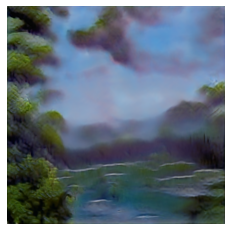

Seed 3001


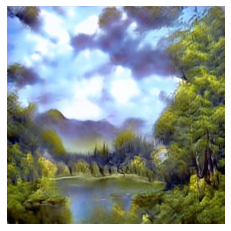

Seed 3002


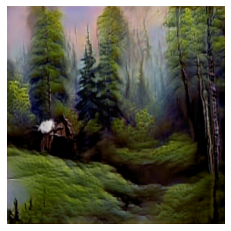

Seed 3003


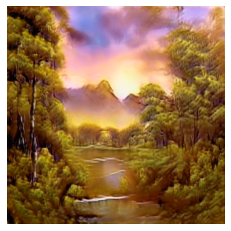

Seed 3004


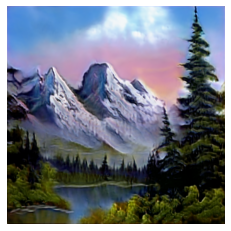

Seed 3005


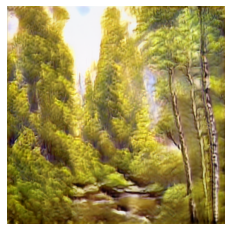

Seed 3006


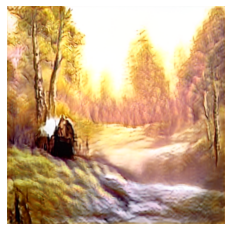

Seed 3007


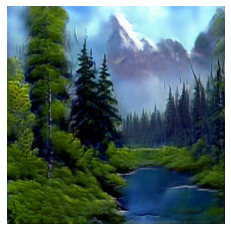

Seed 3008


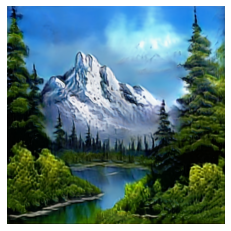

Seed 3009


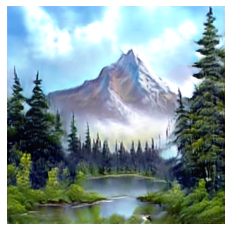

Seed 3010


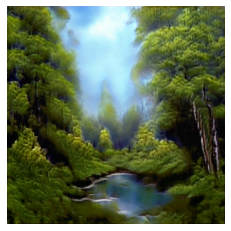

Seed 3011


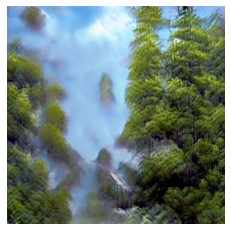

Seed 3012


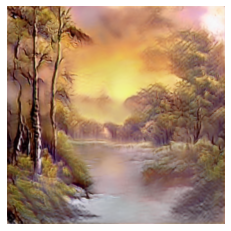

Seed 3013


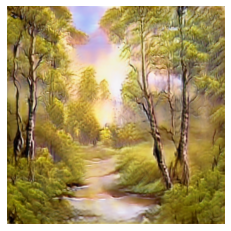

Seed 3014


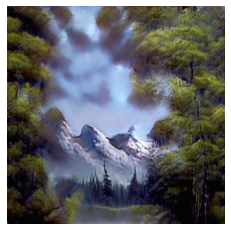

Seed 3015


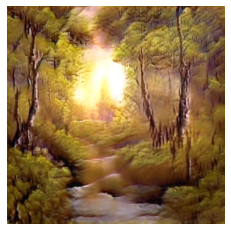

Seed 3016


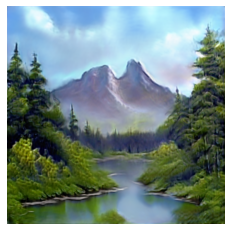

Seed 3017


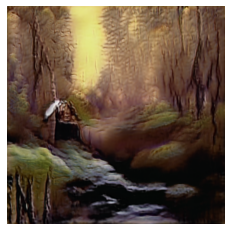

Seed 3018


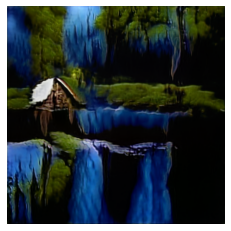

Seed 3019


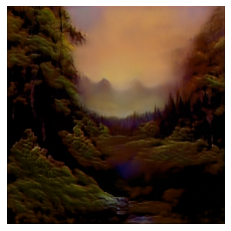

Seed 3020


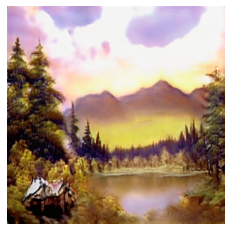

Seed 3021


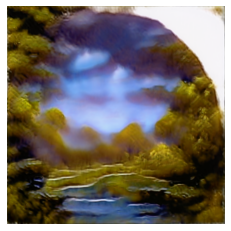

Seed 3022


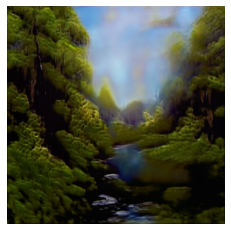

Seed 3023


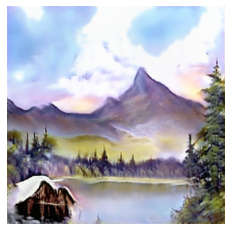

Seed 3024


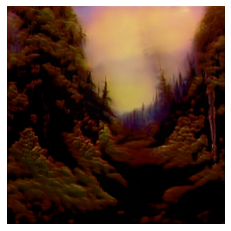

Seed 3025


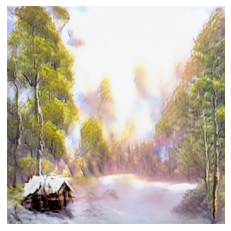

Seed 3026


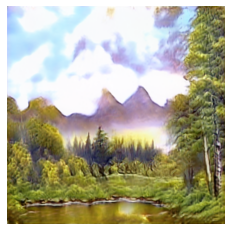

Seed 3027


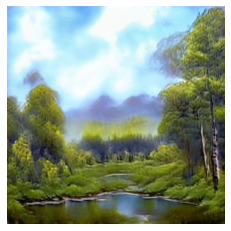

Seed 3028


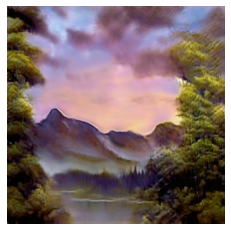

Seed 3029


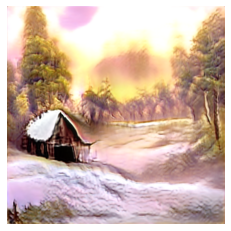

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 3000
SEED_TO = 3030

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)
  img.save(f'./results/seed-{i}.png')
  

delete all photos in /content/results/

In [ ]:
!rm -R /content/results/*

In [ ]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

URL = "/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

vector_size = G.z_dim
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00010-paint-auto1-resumecustom/network-snapshot-000020.pkl"...
(1, 512)


In [ ]:

# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [1000,1001,1002]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 1000:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 1001:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Download your video

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Congrats you made it! you trained your GAN and generated photos and videos. 